In [ ]:
%cd ../

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import ttest_ind 
from sklearn.metrics import confusion_matrix, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv('./data/measurements.csv', decimal=",")
display(data.head())
print(data.shape)

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


(388, 12)


In [3]:
data = data.drop_duplicates()
data.shape

### no duplicates

(388, 12)

In [4]:
data["gas_type"].value_counts()

SP98    228
E10     160
Name: gas_type, dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 0 to 387
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distance       388 non-null    float64
 1   consume        388 non-null    float64
 2   speed          388 non-null    int64  
 3   temp_inside    376 non-null    float64
 4   temp_outside   388 non-null    int64  
 5   specials       93 non-null     object 
 6   gas_type       388 non-null    object 
 7   AC             388 non-null    int64  
 8   rain           388 non-null    int64  
 9   sun            388 non-null    int64  
 10  refill liters  13 non-null     float64
 11  refill gas     13 non-null     object 
dtypes: float64(4), int64(5), object(3)
memory usage: 39.4+ KB


In [6]:
### data classes seem ok!

In [7]:
data.isna().sum()

distance           0
consume            0
speed              0
temp_inside       12
temp_outside       0
specials         295
gas_type           0
AC                 0
rain               0
sun                0
refill liters    375
refill gas       375
dtype: int64

In [8]:
data = data.dropna(subset = ["temp_inside"])
data.shape

(376, 12)

In [9]:
### I will drop column "specials", "refill liters", "refill gas"

data = data.drop(["specials", "refill liters", "refill gas"],axis=1)

In [10]:
data.isna().sum()

distance        0
consume         0
speed           0
temp_inside     0
temp_outside    0
gas_type        0
AC              0
rain            0
sun             0
dtype: int64

In [11]:
data["sun"].value_counts()

0    345
1     31
Name: sun, dtype: int64

In [12]:
### What is the average consumption for each gas type?

data_consumption = data.groupby(["gas_type"]).agg({"consume":"median"}).reset_index()
data_consumption.columns = ["gas_type", "median_consume"]
data_consumption

,gas_type,median_consume
0,E10,4.8
1,SP98,4.7


<AxesSubplot:xlabel='gas_type', ylabel='median_consume'>

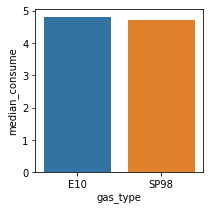

In [13]:
plt.figure(figsize=(3,3))
sns.barplot(x = "gas_type", y = "median_consume", data = data_consumption)

In [14]:
data2 = data.groupby(["gas_type"]).agg({"consume":"median", "distance":"median", "speed":"median"}).reset_index()
data2

,gas_type,consume,distance,speed
0,E10,4.8,15.4,42.0
1,SP98,4.7,14.2,40.0


<AxesSubplot:xlabel='gas_type', ylabel='distance'>

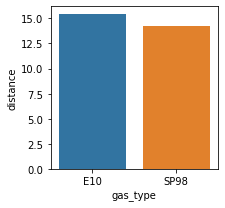

In [15]:
plt.figure(figsize=(3,3))
sns.barplot(x = "gas_type", y = "distance", data = data2)

<AxesSubplot:xlabel='gas_type', ylabel='speed'>

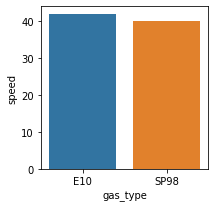

In [16]:
plt.figure(figsize=(3,3))
sns.barplot(x = "gas_type", y = "speed", data = data2)

In [ ]:
### There does not seem to be big differences in the consumption between the different gas 
### types. Neither in the median speed and distance. 

In [17]:
### I will now calculate whether there are significant differences in consume between the two
### different gas types. I will conduct a two-sided unpaired t test

e10 = data[data["gas_type"] == "E10"]
e10 = e10["consume"]
e10 = list(e10)

sp98 = data[data["gas_type"] == "SP98"]
sp98 = sp98["consume"]
sp98 = list(sp98)

print(np.var(e10), np.var(sp98))
ttest_ind(e10, sp98, equal_var=True)

0.8012252018337458 1.2793594795771561


Ttest_indResult(statistic=0.4048222038246352, pvalue=0.6858396411639796)

In [18]:
### There is no significant difference in the consume between E10 and SP98, meaning that
### they consume more or less the same 

In [19]:
### Now I will use a machine learning model to predict consume of petrol. Then I will ask
### what are the most important features and how much they contribute to the consume of petrol

In [20]:
def which_gas(x):
    if x == "E10":
        return 1
    else:
        return 0

In [21]:
data["gas_type"] = data["gas_type"].apply(which_gas)
data

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
0,28.0,5.0,26,21.5,12,1,0,0,0
1,12.0,4.2,30,21.5,13,1,0,0,0
2,11.2,5.5,38,21.5,15,1,0,0,0
3,12.9,3.9,36,21.5,14,1,0,0,0
4,18.5,4.5,46,21.5,15,1,0,0,0
...,...,...,...,...,...,...,...,...,...
383,16.0,3.7,39,24.5,18,0,0,0,0
384,16.1,4.3,38,25.0,31,0,1,0,0
385,16.0,3.8,45,25.0,19,0,0,0,0
386,15.4,4.6,42,25.0,31,0,1,0,0


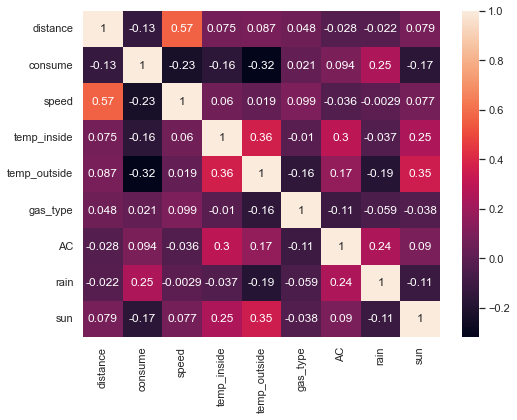

In [22]:
corr_matrix = data.corr()
plt.figure(figsize=(8,6))
sns.set(rc={'figure.figsize':(15,8)})
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [23]:
### There is no multicolinearity between the columns 

In [24]:
### X, y split

X = data.drop("consume", axis = 1)
y = data["consume"]

In [25]:
### Train, test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Shape X train:', X_train.shape)
print('Shape X test:', X_test.shape)
print('Shape y train:', y_train.shape)
print('Shape y test:', y_test.shape)

Shape X train: (300, 8)
Shape X test: (76, 8)
Shape y train: (300,)
Shape y test: (76,)


In [26]:
### MinMaxScaler

scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns, index=X_train.index)
print(X_train_scaled.shape)
X_train_scaled.head()

(300, 8)


,distance,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
116,0.048883,0.157895,0.615385,0.250000,0.0,0.0,1.0,0.0
228,0.054469,0.315789,0.538462,0.222222,0.0,1.0,1.0,0.0
362,0.065642,0.539474,0.461538,0.638889,0.0,0.0,0.0,0.0
204,0.034451,0.184211,0.538462,0.472222,0.0,1.0,1.0,0.0
75,0.060056,0.315789,0.384615,0.333333,0.0,0.0,0.0,0.0


In [27]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns, index=X_test.index)
print(X_test_scaled.shape)
X_test_scaled.head()

(76, 8)


,distance,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
302,0.071229,0.421053,0.461538,0.277778,0.0,1.0,0.0,0.0
369,0.065642,0.368421,0.461538,0.972222,0.0,0.0,0.0,0.0
273,0.431099,0.973684,0.615385,0.638889,1.0,1.0,0.0,1.0
164,0.196462,0.868421,0.384615,0.222222,1.0,0.0,0.0,0.0
152,0.100559,0.618421,0.384615,0.333333,1.0,0.0,1.0,0.0


In [28]:
### Random forest model

n_estimators = [50,100, 150]
max_depth_choices= [3,5,10,15] 
min_samples_split_choices = [2,3,5] 
min_samples_leaf_choices = [1,2,3] 
max_features_choices = ["sqrt", "log2"]

grid = {'n_estimators': n_estimators,
        'max_depth': max_depth_choices,
        'min_samples_split': min_samples_split_choices, 
        'min_samples_leaf': min_samples_leaf_choices,
        'max_features': max_features_choices
       }

In [29]:
rf_reg = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf_reg,
                           param_grid = grid, 
                           cv = 5, 
                           verbose = 2)

In [30]:
rf_grid = grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total ti

[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_sampl

[CV] END max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=3, max_features=log2, min_sam

[CV] END max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END max_depth=3, max_features=log2, min_sam

[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_sampl

[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_

[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=5, max_features=log2, min_sample

[CV] END max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=5, max_features=log2, min_sam

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, 

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min

[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=log2, m

[CV] END max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END max_depth=10, max_features=log2

[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=15, max_features=sqrt, 

[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=150; total time=   0.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=sqrt, min

[CV] END max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=3, n_estimators=50; total time=   0.0s
[CV] END max_depth=15, max_features=log2,

[CV] END max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=150; total time=   0.1s
[CV] END max_depth=15, max_features=log2, 

In [31]:
print('Best parameters:', rf_grid.best_params_)

Best parameters: {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [32]:
### Now for the model

rf_reg = RandomForestRegressor(max_depth = 15, min_samples_split = 5, max_features = "log2",
                              min_samples_leaf = 1, n_estimators = 50)

In [33]:
rf_reg.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=15, max_features='log2', min_samples_split=5,
                      n_estimators=50)

In [34]:
y_train_pred = rf_reg.predict(X_train_scaled)
y_test_pred  = rf_reg.predict(X_test_scaled)

/Users/origenolet/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='consume'>

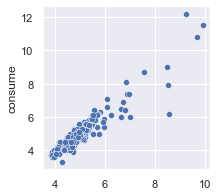

In [35]:
plt.figure(figsize=(3,3))
sns.scatterplot(y_train_pred, y_train)

/Users/origenolet/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='consume'>

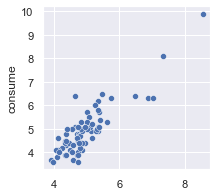

In [36]:
plt.figure(figsize=(3,3))
sns.scatterplot(y_test_pred, y_test)

In [37]:
print("R2 train:", r2_score(y_train, y_train_pred))
print("R2 test:", r2_score(y_test, y_test_pred))
print("MAPE train:", mean_absolute_percentage_error(y_train, y_train_pred))
print("MAPE test:", mean_absolute_percentage_error(y_test, y_test_pred))

R2 train: 0.8612329485531501
R2 test: 0.7341167281388064
MAPE train: 0.0501151050471455
MAPE test: 0.08020266815511486


In [38]:
col = ["distance" ,"speed" ,"temp_inside" ,"temp_outside", "gas_type", "AC", "rain", "sun"]
y =  rf_reg.feature_importances_
df = pd.DataFrame(y, col).reset_index()
df.columns = ["column", "fi"]
df = df.sort_values("fi", ascending=False)
df

,column,fi
0,distance,0.495637
1,speed,0.228674
3,temp_outside,0.147004
2,temp_inside,0.061900
6,rain,0.033048
5,AC,0.014582
4,gas_type,0.011755
7,sun,0.007401


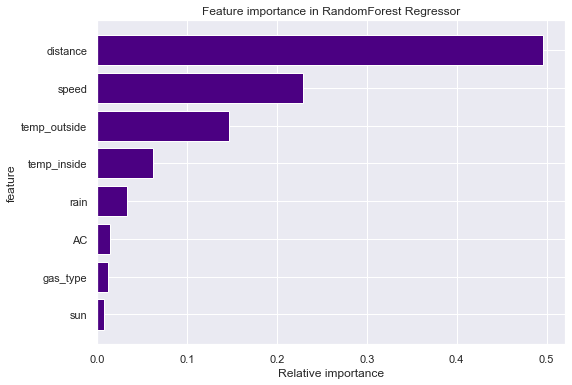

<Figure size 360x360 with 0 Axes>

In [39]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
cols = list(df["column"])
fi = list(df["fi"])
ax.barh(cols,fi, color="indigo")
plt.gca().invert_yaxis()
plt.title("Feature importance in RandomForest Regressor")
plt.xlabel("Relative importance")
plt.ylabel("feature") 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)
plt.show()

In [40]:
### According to the Random Forest Classifier, the most important features that determine 
### consume are distance, speed, and the temperature outside. The temperature inside also 
### seems to have some influence on the petrol consume, but less. 

In [41]:
### Conclusion

### It seems that gas_type has very little to none-at-all influence in petrol consume (we can
### come to the same conclusions both with the EDA as with the random_forest regressor). My
### recommendation would be to switch to E10, as it is cheaper and greener, and does not
### consume more petrol than the SP98! :-)